<div align="center">
<a href="https://vbti.nl"><img src="images/vbti_logo.png" width="400"></a>
</div>

# Reinforcement Learning
This notebook supports the 'Reinforcement Learning' chapter of the [1-day masterclass "Deep Learning"](https://aiblog.nl/masterclass-deep-learning). It is not ment as a full course on deep learning, but rather gives you a flavor of the topic. For an in-depth AI training or consultancy please contact [VBTI](https://vbti.nl). 

Reinforcement Learning is an AI technique to learn an optimal sequence of actions. During the masterclass details of the action-value method, Q-learning, exploration/exploitation, discount factor and Deep Reinforcement Learning are explained. In this notebook you will build and train a RL agent that needs to optimize planning taxi trips.

<div align="center">
<a href="https://aiblog.nl/masterclass-deep-learning"><img src="images/rl.png" width="400"></a>
</div>

In [1]:
# import some default libaries
import numpy as np
import matplotlib.pyplot as plt

# Environment preparation
In this example the [gym tool](https://gym.openai.com) is used to create a simulation environment in which an agent needs to learn a task. The environment used is called 'Taxi-v3'. In this toy environment the agents needs to drive a taxi to pick up and drop passengers. 

> There are 4 locations (labeled by different letters) and your job is to pick up the passenger at one location and drop him off in another. You receive +20 points for a successful dropoff, and lose 1 point for every timestep it takes. There is also a 10 point penalty for illegal pick-up and drop-off actions. (['Taxi-v3'](https://gym.openai.com/envs/Taxi-v3/))

In [2]:
# import and create the simulation environment
import gym
env = gym.make("Taxi-v3")

print("Number of actions : {}".format(env.action_space))
print("Number of states  : {}".format(env.observation_space))

initial_state = env.reset()
print("Initial state     : {}".format(initial_state))

Number of actions : Discrete(6)
Number of states  : Discrete(500)
Initial state     : 327


In [3]:
# render environment
env.render()

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



# Some Base classes

In [4]:
import numpy as np
import matplotlib.pyplot as plt

class Agent:    
    """Abstract Agent class."""
    def reset(self):
        self.rewards = []
        
    def initialize_episode(self):
        self.sum_rewards = 0
    
    def get_action(self, state):
        return None
    
    def update(self, state, action, next_state, reward):
        self.sum_rewards = self.sum_rewards + reward
    
    def finalize_episode(self):
        self.rewards.append(self.sum_rewards)
        
    def get_name(self):
        return self.__class__.__name__

    def plot_rewards(self, ylim=(-100,0)):
        plt.figure(figsize=(18,5))
        plt.plot(self.rewards)
        plt.xlabel('episode')
        plt.ylabel('sum of rewards')
        plt.ylim(ylim)
        plt.title(self.get_name())
        


import time
from IPython.display import clear_output

def run_experiment(environment, agent, n_experiments=1, max_steps=100, render=False, sleep=0.01, n_epoch_update=1000, plot_stats=False):
    # do some bookkeeping
    stats_steps = []
    stats_rewards = []
    stats_penalties = []
    stats_reward_per_step = []
    
    for n in range(n_experiments):
        # reset environment and agent for this episode
        state = environment.reset()
        agent.initialize_episode()
        
        # render environment
        if render:
            environment.render()
            clear_output(wait=True)
            time.sleep(sleep)
        elif n % n_epoch_update ==0: # print progress
            print("Run experiment : {} / {}".format(n, n_experiments))
        
        # episode loop
        steps = 0
        penalties = 0
        done = False
        while (not done) and (steps < max_steps):
            action = agent.get_action(state)
            next_state, reward, done, info = environment.step(action)
            agent.update(state, action, next_state, reward)
            state = next_state
            steps = steps + 1
            
            if render:
                environment.render()
                clear_output(wait=True)
                time.sleep(sleep)
             
            # count penalties
            if reward==-10:
                penalties += 1
            
        agent.finalize_episode()
        stats_penalties.append(penalties)
        stats_steps.append(steps)
        stats_rewards.append(agent.sum_rewards)
        stats_reward_per_step.append(agent.sum_rewards / steps)
    
    if render:
        environment.render()
        print('')
    else:
        print('Done.\n')

    print("Average reward       : {}".format(np.mean(stats_rewards)))
    print("Average #penalties   : {}".format(np.mean(stats_penalties)))
    print("Average #steps       : {}".format(np.mean(stats_steps)))
    print("Average #reward/step : {}".format(np.mean(stats_reward_per_step)))
    
    if plot_stats:
        plt.plot(stats_steps, label='#steps')
        plt.plot(stats_penalties, label='#penalties')
        plt.xlabel('epoch')
        plt.legend()
        



# Build Q-learning Agent
In the masterclass the Q-learning technique is explained. Following this methods, an agent learns to evaluate a state-action combination by using the following rule:

$$
Q(s_t,a_t) \leftarrow Q(s_t,a_t) + \alpha \left[ R_{t+1} +\gamma \max\limits_{a} Q(s_{t+1},a) - Q(s_t,a_t) \right]
$$

The code below implements this rule.

In [5]:
class QLearningAgent(Agent):
    def __init__(self, n_states, n_actions, epsilon=0.1, gamma=0.9, alpha=0.1):
        Agent.__init__(self)
        
        self.n_states = n_states
        self.n_actions = n_actions

        self.epsilon = epsilon
        self.gamma = gamma
        self.alpha = alpha
        
        self.learn = True
                
        self.reset()
        
    def reset(self):
        Agent.reset(self)                
        self.Q = np.zeros((self.n_states, self.n_actions))
                
    def get_action(self, state):
        # e-greedy
        if self.learn & (np.random.random()<self.epsilon): # explore
            a = np.random.randint(self.n_actions)
        else: # exploit
            a = np.argmax(self.Q[state,:])
        return a
    
    def update(self, state, action, next_state, reward):
        if self.learn:
            self.Q[state, action] = self.Q[state, action] + self.alpha * (reward + 
                                                                          self.gamma * np.max(self.Q[next_state,:]) -
                                                                          self.Q[state, action])
        Agent.update(self, state, action, next_state, reward)

In [6]:
# create a Q-learning agent
agent_Q = QLearningAgent(n_states=500, n_actions=6, epsilon=0.1, alpha=0.1, gamma=1.0)

# Train agent
To train a Q-learning agent it needs to try to drive the taxi many times. A maximum duration of 200 steps will be allowed to pick up and drop a passenger. 

First, let's see how well the agents performance without learning. The average performance over 10 experimens is calculated.

In [7]:
# calculate performance of agent
# Note: sometimes the agent does not move but the simulation does run. Be patient! ;)
agent_Q.learn = False
run_experiment(env, agent_Q, n_experiments=10, max_steps=200, render=True)
agent_Q.learn = True

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

Average reward       : -200.0
Average #penalties   : 0.0
Average #steps       : 200.0
Average #reward/step : -1.0


Most likely, the agent will performance very bad (average reward: -200, average number of steps: 200). Therefore 20.000 experiments are carried out during which the agent learns to carry out its job at best.

Run experiment : 0 / 20000
Run experiment : 10000 / 20000
Done.

Average reward       : -2.03835
Average #penalties   : 0.6131
Average #steps       : 17.3745
Average #reward/step : 0.27727722386973236


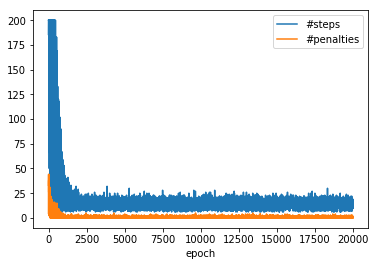

In [8]:
run_experiment(env, agent_Q, n_experiments=20_000, max_steps=200, render=False, n_epoch_update=10_000, plot_stats=True)

The average reward should have increased and the average number of steps should have decreased. We can now measure the performance of the agent after learning by averaging the performance over 10 experiments.

In [9]:
# calculate performance of agent
agent_Q.learn = False
run_experiment(env, agent_Q, n_experiments=10, max_steps=200, render=True, sleep=0.1)
agent_Q.learn = True

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Average reward       : 8.0
Average #penalties   : 0.0
Average #steps       : 13.0
Average #reward/step : 0.627062937062937


# How to go further from here?
This notebook provides a basic processing pipeline for building a reinforcement learning agent that learns to carry out a job. Experiment a little bit yourself by changing the exploration parameter epsilon and discount factor gamma. Try to increase the reward or shorten the training time.